### Тестовое Задание 

### 1. Python

- В python2.7 есть ф-ции `range()` и `xrange()`, в чем разница? 

**Ответ:** 

Функция `range()` возвращает объект список, а `xrange()` объект генератор. Основная идея - эффективное использование памяти. 

Например, при создании последовательности функцией `range()` необходимо выделить память согласно размеру последовательности.
При очень больших последовательностях мы столкнемся с проблемой нехватки памяти (RAM).

Функция `xrange()` решает данную проблему, здесь при генерации последовательности будет создан объект генератор. Генераторы генерируют свои элементы по мере необходимости, а не сразу, следовательно, позволяют экономить и эффективно использовать память.

Однако в Python 3 функции `xrange()` нет, только `range()`. Чтобы использовать генератор, мы должны его явно использовать

Рассмотрим на примере:

In [1]:
# Генерация очень большой последовательности (10**12) при помощи range() 
# очень долго создается и большое потребление памяти (поэтому код закомментирован)
# my_list = [x for x in range(10**12)] 

In [2]:
# Аналогично, но используя генератор 
my_gen = (x for x in range(10**12))
my_gen

<generator object <genexpr> at 0x000001D2CFFC15C8>

Говоря про функции `range()` и `xrange()` мы сталкиваемся с понятиями **итераторы и генераторы**, где:
- **Итератор**: объект перечислитель, отвечающий на вопрос "Какой элемент следующий?" и возвращающий ошибку `StopIteration` если объекты в последовательности закончились. Они позволяют нам перебирать элементы собственных классов.


- **Генератор**: удобный синтаксис для написания итераторов, обычно может быть определен как функция, где вместо слова `return()` используется `yeild()` и вместо возвращения происходит генерация следующего значения последовательности.

Также, генераторы "помнят" последнее значение, если мы совершили какое то действие, например вызвали оператор `break`, то при последующей итерации мы начнем не с начала последовательности, а с предыдущего значения на котором остановились

In [3]:
# Последовательность до break
for item in my_gen:
    print(item, end=' ')
    if item == 4:
        break

0 1 2 3 4 

In [4]:
# Последовательность после break
for item in my_gen:
    print(item, end=' ')
    if item == 10:
        break

5 6 7 8 9 10 

- Написать на Python 2 или 3 генератор первых n чисел фибоначчи

Сигнатура: `def fibonacci_generator(n)`

**Пример использования:** вывести первые 10 числе фибоначчи:

`
n = 10
for num in fibonacci_generator(n):
    print(num)
`

In [5]:
def fibonacci_generator(n):
    """
    Генерирует n значений последовательности Фибоначчи 
    
    n: int
        Число элементов последовательности
    Returns:
    --------
    generator object
        Генератор с n-значениями последовательности Фибоначчи  
    
    """
    try:
        assert(isinstance(n, int)) # Значениями последовательности могут быть только целочисленными
    except AssertionError:
        print('Значениями последовательности (n) могут быть только целочисленные значения')
        return False
        
    a, b = 0, 1 # первые элементы последовательности Фибоначчи 
    for _ in range(n):
        yield a 
        a, b = b, a+b 

In [6]:
n = 10
for num in fibonacci_generator(n):
    print(num, end=' ') 

0 1 1 2 3 5 8 13 21 34 

### 2. SQL
Исходная таблица данных 
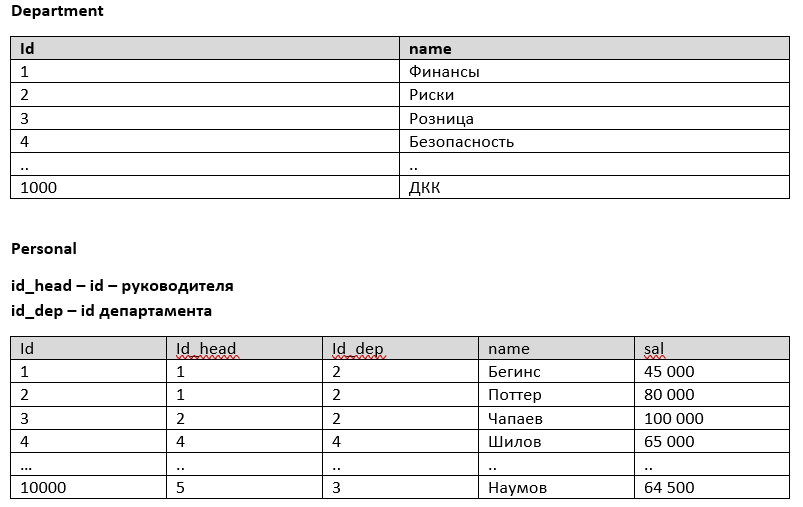
- Вывести отдел с наибольшим числом сотрудников

- Вывести список сотрудников, получающих заработную плату выше, чем у руководителя

### 3. Предсказание Отрасли Компании
Необходимо по данным о платежах между компаниями предсказать их отрасль

Основные таблицы:
- **pays**: Платежи между компаниями
- **inn_info_public**: Информация по компаниям (отрасль/регион)

Признаки:
- `hash_inn_kt`: Обезличенный ИНН отправителя
- `hash_inn_dt`: Обезличенный ИНН получателя
- `week`: Неделя
- `count`: Количество платежей в неделю
- `sum`: Сумма платежей в неделю 


- `hash_inn`: ИНН
- `okved2`: Отрасль (Таргет)
- `region`: Регион
- `is_public`: флаг(train/test)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

import warnings
from collections import Counter

SEED = 23
warnings.filterwarnings("ignore")

### Первоначальный Анализ Данных (EDA)
Для начала просто взглянем на данные, их размерность, есть ли пропуски и проверим корректность некоторых значений

In [8]:
# Загрузка данных 
pays_data = pd.read_csv('pays.csv')
comp_info_data = pd.read_csv('inn_info_public.csv')

print('pays_data shape: ', pays_data.shape)
print('comp_info_data shape: ', comp_info_data.shape)

pays_data shape:  (5430150, 5)
comp_info_data shape:  (240069, 4)


In [9]:
# Имеются ли пропуски
print('pays_data total NaN: ', pays_data.isna().sum().sum())
print('comp_info_data total NaN: ', comp_info_data.isna().sum().sum())

pays_data total NaN:  1125
comp_info_data total NaN:  0


В таблице с платежами имеем часть пропусков, сперва взглянем на эти значения 

In [10]:
pays_data[pays_data['sum'].isna()]

,hash_inn_kt,hash_inn_dt,week,count,sum
2400,263,263,12,0,NaN
2401,263,263,13,0,NaN
2402,263,263,14,0,NaN
73323,3430,3430,19,0,NaN
74124,3493,3493,8,0,NaN
...,...,...,...,...,...
5402624,259374,259374,16,0,NaN
5402625,259374,259374,20,0,NaN
5408484,259705,259705,16,0,NaN
5424576,260125,260125,6,0,NaN


Между такими компаниями платежи не совершались. На данном этапе **данные значения удалять не будем, а просто заполним нулём**

In [11]:
pays_data.fillna(0, inplace=True)

In [12]:
# Взглянем на статистики по pays_data
round(pays_data.describe(), 2)

,hash_inn_kt,hash_inn_dt,week,count,sum
count,5430150.00,5430150.00,5430150.00,5430150.00,5430150.00
mean,128877.52,130520.33,11.62,2.92,393.86
std,75696.51,75646.41,6.33,5.05,7258.67
min,0.00,0.00,0.00,0.00,-0.40
25%,62929.00,64761.00,6.00,1.00,3.28
50%,127381.00,129588.00,12.00,2.00,14.56
75%,194385.00,196606.00,17.00,3.00,69.17
max,260511.00,260515.00,23.00,2530.00,3966399.60


Есть наблюдения где признак `sum` отрицательный. Возможно это ошибка, сумма по платежам не может быть отрицательной.

В описании к заданию об этом ничего не сказано. Однако пока не будем вносить какие-либо корректировки или удалять данные наблюдения.

**Рассмотрим распределение признаков** `week`, `count`, `sum`

Если строить распределение "в лоб", то получается очень неинформативно (данных много, распределения будут иметь длинные хвосты)

Поэтому будем рассматривать на некотором начальном промежутке (от 0 до N)

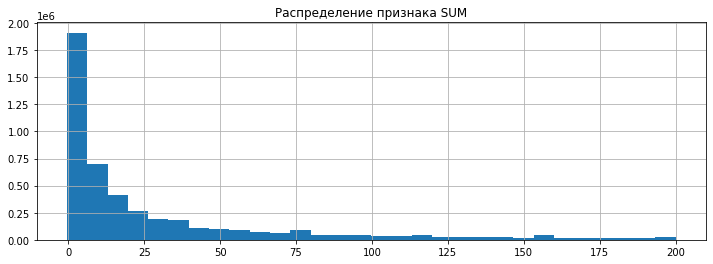

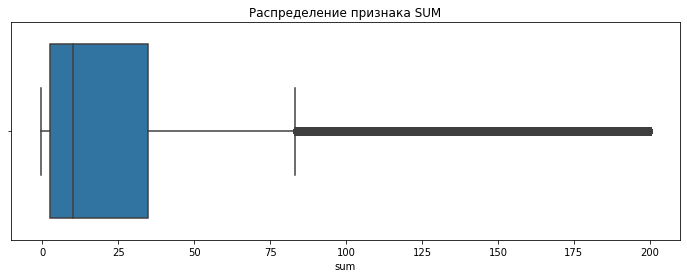

In [13]:
# Большая часть данных будет все равно расценена как выбросы, поэтом будем рассматривать диапазон от 0 до 200
data = pays_data[pays_data['sum'] < 200]['sum']

plt.figure(figsize=(12, 4))
data.hist(bins=30)
plt.title('Распределение признака SUM');

plt.figure(figsize=(12, 4))
sns.boxplot(data)
plt.title('Распределение признака SUM');

Большая сумма платежей в неделю небольшая и обычно не превышает 25/40 (Q3)

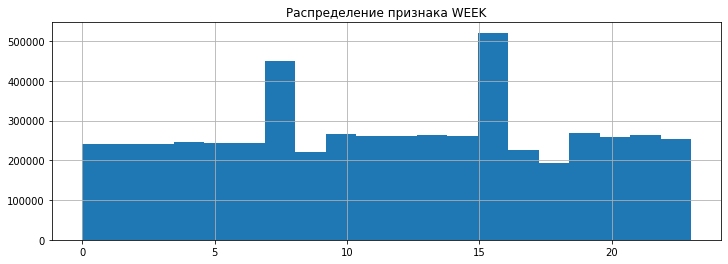

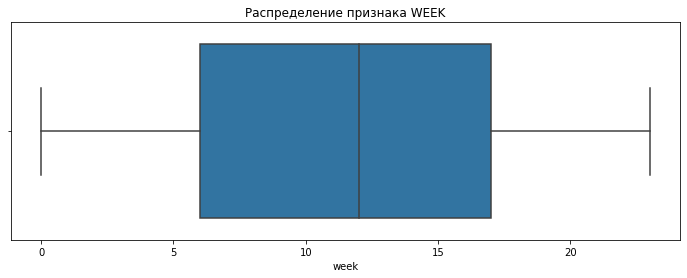

In [14]:
plt.figure(figsize=(12, 4))
pays_data['week'].hist(bins=20)
plt.title('Распределение признака WEEK');

plt.figure(figsize=(12, 4))
sns.boxplot(pays_data['week'])
plt.title('Распределение признака WEEK');

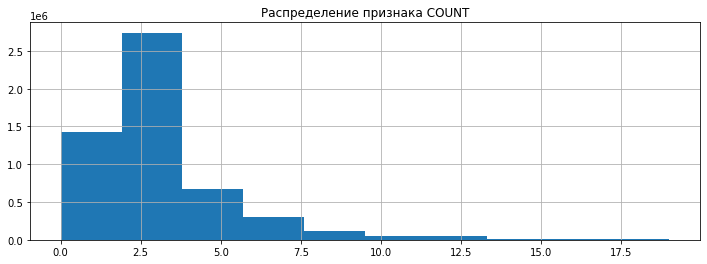

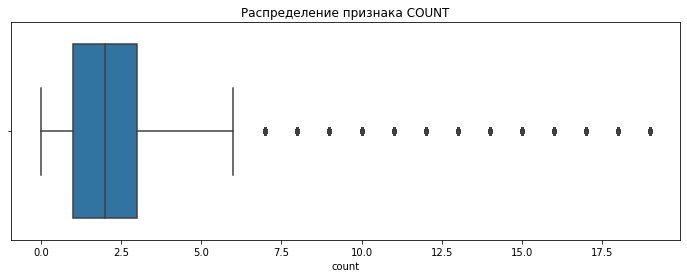

In [15]:
data = pays_data[pays_data['count'] < 20]['count']

plt.figure(figsize=(12, 4))
data.hist(bins=10)
plt.title('Распределение признака COUNT');

plt.figure(figsize=(12, 4))
sns.boxplot(data)
plt.title('Распределение признака COUNT');

Чило платежей в неделю, обычно небольшое: от 3 до 5

In [16]:
# Взглянем на статистики по comp_info_data
round(comp_info_data.describe(), 2)

,hash_inn,okved2,region
count,240069.00,240069.00,240069.00
mean,130236.42,18.77,58.94
std,75201.51,22.08,26.94
min,0.00,-1.00,0.00
25%,65170.00,-1.00,37.00
50%,130169.00,12.00,60.00
75%,195380.00,34.00,84.00
max,260515.00,79.00,90.00


Здесь нас интересует лишь распределение для таргета `okved2` и регионов `region`

In [17]:
# Изменим типы для удобной визуализации
comp_info_data['region'] = comp_info_data['region'].astype('str')
comp_info_data['okved2'] = comp_info_data['okved2'].astype('str')
comp_info_data['hash_inn'] = comp_info_data['hash_inn'].astype('str')

# Столбец is_public нам не нужен (легко определим по okved2 = -1)
comp_info_data.drop(columns='is_public', inplace=True)

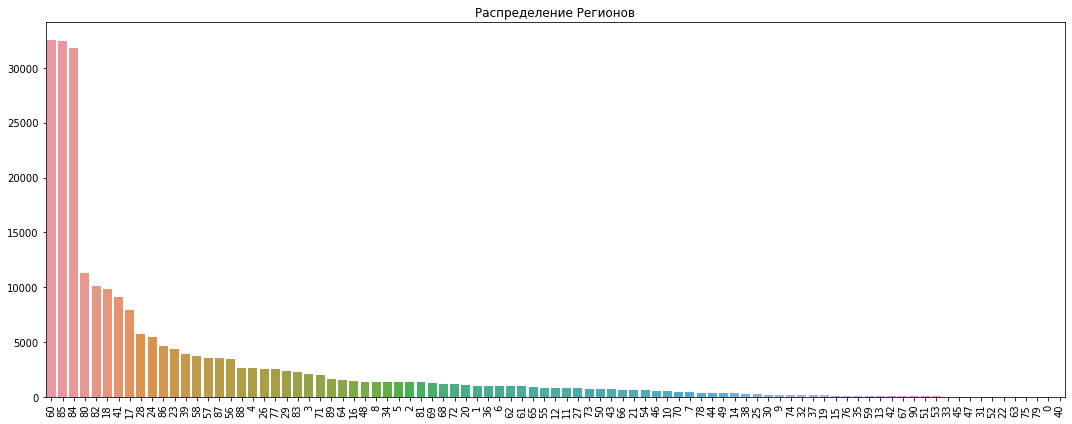

In [18]:
# Распределение по регионам
plt.figure(figsize=(15, 6))
df_regions = comp_info_data['region'].value_counts()
sns.barplot(df_regions.index, df_regions.values)
plt.xticks(rotation=90)
plt.title('Распределение Регионов')
plt.tight_layout();

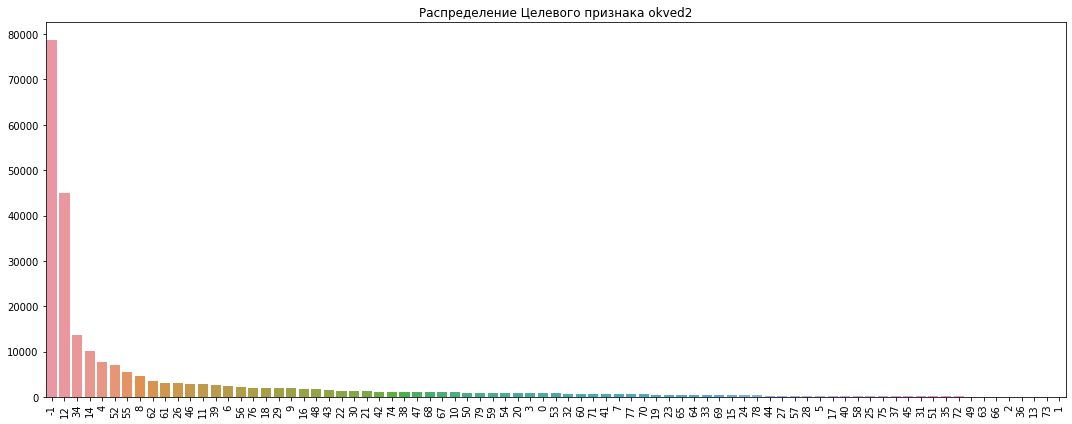

In [19]:
# Распределение целевой переменной 
plt.figure(figsize=(15, 6))
df_target = comp_info_data['okved2'].value_counts()
sns.barplot(df_target.index, df_target.values)
plt.xticks(rotation=90)
plt.title('Распределение Целевого признака okved2')
plt.tight_layout();

Видим наш целевой класс -1 для которого необходимо совершить предсказание. 

Имеем задачу многоклассовой классификации на 80 классов, классы несбалансированы.

### Подход к Решению Задачи
Мы имеем список различных компаний, совершавшие платежи/перводы между собой или другими компаниями. Мы знаем число платежей и их сумму за определенную неделю.

Основными признаками для модели будут различные статистики, основанные на признаках `sum`, `count`, `week`, `region` а также связи между компаниями по отраслям. Примеры нескольких гипотез по созданию признаков:
- Среднее число платежей/сумма платежей компании в неделю
- Среднее число платежей/сумму платежей для каждой отрасли
- Регион отправителя/получателя
- В рамках одно ли региона транзакция?
- ...


Итоговая матрица признаков будет иметь следующую структуру:
- Объекты: компании (hash_inn)
- Признаки: признаки компаний отправителей и получателей

Причем некоторые компании являлись только отправителями или только получателями, однако **в итоговой матрице признаков должны быть все компании.** Для компаний которые не являлись отправителями/получателями мы просто будем иметь нулевые признаки.


### Разделение на Train/Test
Расчет основных признаков для модели будем производить на всем наборе данных. 

Признаки для *test* будут считаться аналогично как и для *train* (никакого лика в данных мы не допускаем). 

После получение признаков, просто отберем тестовую выборку по правилу `okved == -1`

### Feature Engineering
Генерацию признаков для модели будем производить отдельно для получателей и отправителей. Затем полученные признаки объеденим и используем для классификации.

In [20]:
# Сперва взглянем сколько уникальных компаний мы имеем
senders = pays_data['hash_inn_kt'].value_counts()
receivers = pays_data['hash_inn_dt'].value_counts()

print('Чило Компаний Отправителей: ', senders.shape[0])
print('Чило Компаний Получателей: ', receivers.shape[0])
print('Общее Число Компаний: ', len(set(senders.index).union(set(receivers.index))))

Чило Компаний Отправителей:  152160
Чило Компаний Получателей:  189772
Общее Число Компаний:  240071


Сформируем основную таблицу по отправителям/получателям

In [21]:
# Добавим компании которые не имеют получателей 
unique_senders = set(senders.index)
unique_receivers = set(receivers.index)

missing_senders = pd.DataFrame()
missing_senders['hash_inn_kt'] = list(unique_receivers - unique_senders)
missing_senders['hash_inn_dt'] = np.nan
missing_senders['week'] = np.nan
missing_senders['count'] = np.nan
missing_senders['sum'] = np.nan

pays_data = pays_data.append(missing_senders, ignore_index=True)

In [22]:
# Для успешного присоединения, необходимо вернуть тип int для таблицы comp_info_data
comp_info_data = comp_info_data.apply(pd.to_numeric)

# Присоединяем данные по отправителям
main_data = pd.merge(pays_data, comp_info_data[['hash_inn', 'region']], how='left', left_on='hash_inn_kt', right_on='hash_inn')

# Присоединяем данные по получателям
main_data = pd.merge(main_data, comp_info_data[['hash_inn', 'region']], how='left', left_on='hash_inn_dt', right_on='hash_inn', suffixes=['_sen', '_rec'] )

main_data.drop(columns=['hash_inn_kt', 'hash_inn_dt'], inplace=True)
main_data

,week,count,sum,hash_inn_sen,region_sen,hash_inn_rec,region_rec
0,1.0,4.0,38399.6,0.0,84.0,0.0,84.0
1,5.0,2.0,399.6,0.0,84.0,0.0,84.0
2,7.0,2.0,79.6,0.0,84.0,0.0,84.0
3,9.0,2.0,239.6,0.0,84.0,0.0,84.0
4,12.0,2.0,79.6,0.0,84.0,0.0,84.0
...,...,...,...,...,...,...,...
5518056,NaN,NaN,NaN,260508.0,26.0,NaN,NaN
5518057,NaN,NaN,NaN,260512.0,26.0,NaN,NaN
5518058,NaN,NaN,NaN,260513.0,36.0,NaN,NaN
5518059,NaN,NaN,NaN,260514.0,83.0,NaN,NaN


In [23]:
%%time 
# Разобьем по отправителям и получателям 

# Отправители 
senders_data = main_data\
    .groupby('hash_inn_sen', as_index=False)\
    .agg({
        'region_sen': 'first', # регион отправителя
        'week': lambda x: list(x),
        'count': lambda x: list(x),
        'sum': lambda x: list(x),
        'hash_inn_rec': lambda x: list(x), # компания и её получатели
        'region_rec': lambda x: list(x) # регионы получателей
    }) 

# Получатели
receivers_data = main_data\
    .groupby('hash_inn_rec', as_index=False)\
    .agg({
        'region_rec': 'first', # регион получателя
        'week': lambda x: list(x),
        'count': lambda x: list(x),
        'sum': lambda x: list(x),
        'hash_inn_sen': lambda x: list(x), # компания и её отправители
        'region_sen': lambda x: list(x) # регионы отправителей
    }) 

Wall time: 58.7 s


- **Число уникальных получателей/отправителей**

In [24]:
%%time
senders_data['n_unique_receivers'] = senders_data['hash_inn_rec'].apply(lambda x: np.unique(x).shape[0])
receivers_data['n_unique_senders'] = receivers_data['hash_inn_sen'].apply(lambda x: np.unique(x).shape[0])

Wall time: 4.37 s


- **Наличие платежа на каждую неделю**

In [25]:
%%time

# Nan исключаем
unique_weeks = sorted(pays_data['week'].unique().tolist())[:-1]
for week_n in unique_weeks:
    senders_data[f'has_pay_on_{week_n}_week_sen'] = senders_data['week'].apply(lambda x: 1 if week_n in x else 0)
    receivers_data[f'has_pay_on_{week_n}_week_rec'] = senders_data['week'].apply(lambda x: 1 if week_n in x else 0)

Wall time: 5.03 s


- **Cтатистики по уникальным неделям и разницы между уникальными неделями**

Для расчета основных статистик определим функцию `get_statistics()`

In [26]:
%%time
# Сперва получим список уникальных недель для отправителей/получателей 
senders_data['n_unique_weeks_sen'] = senders_data['week'].apply(lambda x: np.unique(x))
receivers_data['n_unique_weeks_rec'] = receivers_data['week'].apply(lambda x: np.unique(x))

# Список для разницы между уникальными неделями (отправители/получатели)
senders_data['n_unique_weeks_diff_sen'] = senders_data['n_unique_weeks_sen'].apply(np.diff)
receivers_data['n_unique_weeks_diff_rec'] = receivers_data['n_unique_weeks_rec'].apply(np.diff)

Wall time: 6.43 s


In [27]:
%%time

# Расчитывае основные статистики по признакам
def get_statistics(df, col_name, stat_func_lst, suffix=''):
    """
    Расчет различных статистик для признака
    
    df: DataFrame
        Исходный DataFrame признаков 
    
    col_name: str
        Название признака
        
    stat_func_lst: list
        Список с необходимыми статистиками 
        
    Returns:
    -------
    None
    
    """
    feature_name = df[col_name].name
    
    if suffix:
        feature_name = feature_name + suffix
    
    for func in stat_func_lst:
        if func.__name__ == 'quantile':
            # Расчёт Q1
            df[feature_name + func.__name__ + '_q_1'] = df[col_name].apply(lambda x: 0 if len(x) == 0 else func(x, q=0.25))
            # Расчёт Q3
            df[feature_name + func.__name__ + '_q_3'] = df[col_name].apply(lambda x: 0 if len(x) == 0 else func(x, q=0.75))
        else:
            df[feature_name + func.__name__] = df[col_name].apply(lambda x: 0 if len(x) == 0 else func(x))

# Список используемых статистик 
stat_func_list = [min, max, len, np.sum, np.mean, np.median, np.std, np.quantile]

# Расчитываем статистики по необходимым признакам
get_statistics(df=senders_data, col_name='n_unique_weeks_sen', stat_func_lst=stat_func_list, suffix='_')
get_statistics(df=senders_data, col_name='n_unique_weeks_diff_sen', stat_func_lst=stat_func_list, suffix='_')

get_statistics(df=receivers_data, col_name='n_unique_weeks_rec', stat_func_lst=stat_func_list, suffix='_')
get_statistics(df=receivers_data, col_name='n_unique_weeks_diff_rec', stat_func_lst=stat_func_list, suffix='_')

Wall time: 2min 45s


- **Статистики по признаку `count`**

In [28]:
%%time
get_statistics(df=senders_data, col_name='count', stat_func_lst=stat_func_list, suffix='_sen_')
get_statistics(df=receivers_data, col_name='count', stat_func_lst=stat_func_list, suffix='_rec_')

Wall time: 2min


- **Статистики по признаку `sum`**

In [29]:
%%time
get_statistics(df=senders_data, col_name='sum', stat_func_lst=stat_func_list, suffix='_sen_')
get_statistics(df=receivers_data, col_name='sum', stat_func_lst=stat_func_list, suffix='_rec_')

Wall time: 1min 54s


- **Количество нулевых `sum`**

In [30]:
%%time
senders_data['n_zeros_sum_sen'] = senders_data['sum'].apply(lambda x: x.count(0))
receivers_data['n_zeros_sum_rec'] = receivers_data['sum'].apply(lambda x: x.count(0))

Wall time: 429 ms


- **Статистики по положительный и отрицатеьным `sum`**

In [31]:
%%time
# Определяем положительные/отрицательные значения признака sum
senders_data['neg_sum_sen'] = senders_data['sum'].apply(lambda sum_val: [x for x in sum_val if x < 0])
senders_data['pos_sum_sen'] = senders_data['sum'].apply(lambda sum_val: [x for x in sum_val if x > 0])

receivers_data['neg_sum_rec'] = senders_data['sum'].apply(lambda sum_val: [x for x in sum_val if x < 0])
receivers_data['pos_sum_rec'] = senders_data['sum'].apply(lambda sum_val: [x for x in sum_val if x > 0])

# Nan заменяем на пустые списки
senders_data['neg_sum_sen'] = senders_data['neg_sum_sen'].apply(lambda x: [] if x is np.nan else x)
senders_data['pos_sum_sen'] = senders_data['pos_sum_sen'].apply(lambda x: [] if x is np.nan else x)

receivers_data['neg_sum_rec'] = receivers_data['neg_sum_rec'].apply(lambda x: [] if x is np.nan else x)
receivers_data['pos_sum_rec'] = receivers_data['pos_sum_rec'].apply(lambda x: [] if x is np.nan else x)

Wall time: 2.69 s


In [32]:
%%time

# Расчёт статистик по neg_sum/pos_sum
get_statistics(df=senders_data, col_name='neg_sum_sen', stat_func_lst=stat_func_list, suffix='_')
get_statistics(df=senders_data, col_name='pos_sum_sen', stat_func_lst=stat_func_list, suffix='_')

get_statistics(df=receivers_data, col_name='neg_sum_rec', stat_func_lst=stat_func_list, suffix='_')
get_statistics(df=receivers_data, col_name='pos_sum_rec', stat_func_lst=stat_func_list, suffix='_')

Wall time: 1min 32s


- **Количество уникальных регионов `region`**

In [33]:
# Уникальные регионы получателей от отправителя 
senders_data['n_unique_reg_rec'] = senders_data['region_rec'].apply(np.unique)

# Уникальные регионы отправителей для получателя 
receivers_data['n_unique_reg_sen'] = receivers_data['region_sen'].apply(np.unique)

In [34]:
%%time
# Количество уникальных регионов 
senders_data['n_unique_reg_count_rec'] = senders_data['n_unique_reg_rec'].apply(lambda x: 0 if len(x) == 0 else len(x))
receivers_data['n_unique_reg_count_sen'] = receivers_data['n_unique_reg_sen'].apply(lambda x: 0 if len(x) == 0 else len(x))

Wall time: 285 ms


In [35]:
senders_col_to_drop = [ 'week', 'count', 'sum', 
                       'hash_inn_rec', 'region_rec', 
                       'n_unique_weeks_sen', 'n_unique_weeks_diff_sen',
                       'neg_sum_sen', 'pos_sum_sen', 'n_unique_reg_rec']

receivers_col_to_drop = ['week', 'count', 'sum',
                         'hash_inn_sen', 'region_sen',
                         'n_unique_weeks_rec', 'n_unique_weeks_diff_rec',
                         'neg_sum_rec', 'pos_sum_rec', 'n_unique_reg_sen']

In [36]:
# # Признаки по отправителям/получателям
senders_features = senders_data.drop(columns=senders_col_to_drop)
receivers_features = receivers_data.drop(columns=receivers_col_to_drop)

# # Объединение признаков 
features_df = pd.merge(senders_features, receivers_features, how='left', left_on='hash_inn_sen', right_on='hash_inn_rec')
features_df.fillna(0, inplace=True)
features_df.drop(columns='hash_inn_rec', inplace=True)

### Baseline Model
В качестве основной модели выберем градиентный бустинг: `LGBMClassifier`

Качество модели будем отслеживать при помощи кросс-валидации: `StratifiedKFold`

Основные метрики: `precison, recall, f1` c параметрами `average = weighted`

In [37]:
# Добавим таргет 
data = pd.merge(features_df, comp_info_data[['hash_inn', 'okved2']], how='left', left_on='hash_inn_sen', right_on='hash_inn')
data.drop(columns='hash_inn', inplace=True)

In [49]:
%%time

# Test Data
inference_df = data[data['okved2'] < 0]

# Train Data
train_data = data[data['okved2'] != -1]

# Отберём матрциу признаков X и таргет y
X = train_data.drop(columns=['hash_inn_sen', 'region_sen', 'region_rec', 'okved2'])
y = train_data['okved2']

# Определяем основной разрез метрик
scoring = {
           'precision' : make_scorer(precision_score, average='weighted'),
           'recall' : make_scorer(recall_score, average='weighted'),
           'f1_score' : make_scorer(f1_score, average='weighted')
          }

# Определяем модель 
model = LGBMClassifier(n_estimators=100,
                       max_depth=5,
                       num_leaves=25,
                       learning_rate=0.1,
                       objective='multiclass',
                       class_weight='balanced',
                       silent=True,
                       n_jobs=-1,
                       random_state=SEED)

# Кросс-Валидируемся
cv_results = cross_validate(model,
                            X=X, y=y,
                            cv=StratifiedKFold(shuffle=True, random_state=SEED, n_splits=3),
                            scoring=scoring,
                            error_score='raise')

# Результаты 
cv_df = pd.DataFrame(cv_results)
cv_df[cv_df.columns[2:]].mean()

Wall time: 6min 32s


test_precision    0.251691
test_recall       0.075736
test_f1_score     0.089706
dtype: float64

**Полученное качество не впечатляет, необходимо попробовать другие признаки** 

Выходит, что предыдущие евристики неверны и необходимо рассмотреть другие гипотезы

### Признаки в Разрезе Недель и Отраслей
Проверим как повлияют на качество модели признаки:
- Среднее число платежей в неделю
- Средняя сумма платежей в неделю
- Средне число платежей для каждой отрасли
- Средняя сумма платежей в неделю для каждой отрасли

**Для начала построим данные признаки для отправителей.** Если качество улучшится, добавим и для получателей

In [50]:
# Основная матрица признаков
comp_info_data = comp_info_data.apply(pd.to_numeric)
main_features_df = comp_info_data[['hash_inn', 'okved2']]
main_features_df.head()

,hash_inn,okved2
0,61058,34
1,8311,18
2,130273,-1
3,64081,43
4,218005,12


In [51]:
# Среднее число платежей (Отправители)
senders_week_count_avg = pays_data.pivot_table(index='hash_inn_kt',
                                               columns='week',
                                               values='count',
                                               aggfunc='mean',
                                               fill_value=0)
# Считаем среднее
senders_week_count_avg = senders_week_count_avg.mean(axis=1)\
                                               .reset_index()\
                                               .rename(columns={0: 'mean_count_week_sen'})

senders_week_count_avg.rename(columns={'hash_inn_kt': 'sender_hash'}, inplace=True)

# Добавляем фичу
main_features_df = pd.merge(main_features_df, senders_week_count_avg, how='left',
                            left_on='hash_inn', right_on='sender_hash').drop(columns='sender_hash')

# Если ИНН не являлся отправителем, то просто в признаке будет NaN, мы заменим NaN на 0
main_features_df.fillna(0, inplace=True)
main_features_df.head()

,hash_inn,okved2,mean_count_week_sen
0,61058,34,0.000000
1,8311,18,0.000000
2,130273,-1,0.166667
3,64081,43,0.000000
4,218005,12,0.833333


In [52]:
# Средняя сумма платежей в неделю (Отправители)
senders_week_sum_avg = pays_data.pivot_table(index='hash_inn_kt',
                                             columns='week',
                                             values='sum',
                                             aggfunc='mean',
                                             fill_value=0)

# Считаем среднее
senders_week_sum_avg = senders_week_sum_avg.mean(axis=1)\
                                           .reset_index()\
                                           .rename(columns={0: 'mean_sum_week_sen'})

senders_week_sum_avg.rename(columns={'hash_inn_kt': 'sender_hash'}, inplace=True)

# Добавляем фичу
main_features_df = pd.merge(main_features_df, senders_week_sum_avg, how='left',
                            left_on='hash_inn', right_on='sender_hash').drop(columns='sender_hash')

main_features_df.head()

,hash_inn,okved2,mean_count_week_sen,mean_sum_week_sen
0,61058,34,0.000000,NaN
1,8311,18,0.000000,NaN
2,130273,-1,0.166667,25.466667
3,64081,43,0.000000,NaN
4,218005,12,0.833333,32.479167


In [53]:
# Присоеденим отрасли для признаков mean_count_week_sen/mean_sum_week_sen
senders_week_count_avg = pd.merge(senders_week_count_avg, comp_info_data[['hash_inn', 'okved2']],
                                  how='left', left_on='sender_hash', right_on='hash_inn').drop(columns='hash_inn')

senders_week_sum_avg = pd.merge(senders_week_sum_avg, comp_info_data[['hash_inn', 'okved2']],
                                  how='left', left_on='sender_hash', right_on='hash_inn').drop(columns='hash_inn')

In [54]:
# Средне число платежей для каждой отрасли (Отправители)
industry_mean_count_sen = senders_week_count_avg.pivot_table(index='sender_hash',
                                                             columns='okved2',
                                                             values='mean_count_week_sen',
                                                             aggfunc='mean',
                                                             fill_value=0)

# Переименуем фичи
count_feat_names = [f'mean_count_ind_sen_{i}' for i in range(80)]
count_new_names = {indx: feat_name for (indx, feat_name) in enumerate(count_feat_names)}

industry_mean_count_sen.rename(columns=count_new_names, inplace=True)
industry_mean_count_sen.drop(columns=-1, inplace=True)

# Добавляем фичу
main_features_df = pd.merge(main_features_df, industry_mean_count_sen, how='left',
                            left_on='hash_inn', right_on='sender_hash')

main_features_df.head()

,hash_inn,okved2,mean_count_week_sen,mean_sum_week_sen,mean_count_ind_sen_0,mean_count_ind_sen_1,mean_count_ind_sen_2,mean_count_ind_sen_3,mean_count_ind_sen_4,mean_count_ind_sen_5,...,mean_count_ind_sen_70,mean_count_ind_sen_71,mean_count_ind_sen_72,mean_count_ind_sen_73,mean_count_ind_sen_74,mean_count_ind_sen_75,mean_count_ind_sen_76,mean_count_ind_sen_77,mean_count_ind_sen_78,mean_count_ind_sen_79
0,61058,34,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8311,18,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,130273,-1,0.166667,25.466667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,64081,43,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,218005,12,0.833333,32.479167,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Средняя сумма платежей для каждой отрасли (Отправители)
industry_mean_sum_sen = senders_week_sum_avg.pivot_table(index='sender_hash',
                                                         columns='okved2',
                                                         values='mean_sum_week_sen',
                                                         aggfunc='mean',
                                                         fill_value=0)

# Переименуем фичи
sum_feat_names = [f'mean_sum_ind_sen_{i}' for i in range(80)]
sum_new_names = {indx: feat_name for (indx, feat_name) in enumerate(sum_feat_names)}

industry_mean_sum_sen.rename(columns=sum_new_names, inplace=True)
industry_mean_sum_sen.drop(columns=-1, inplace=True)

# Добавляем фичу
main_features_df = pd.merge(main_features_df, industry_mean_sum_sen, how='left',
                             left_on='hash_inn', right_on='sender_hash')
main_features_df.head()

,hash_inn,okved2,mean_count_week_sen,mean_sum_week_sen,mean_count_ind_sen_0,mean_count_ind_sen_1,mean_count_ind_sen_2,mean_count_ind_sen_3,mean_count_ind_sen_4,mean_count_ind_sen_5,...,mean_sum_ind_sen_70,mean_sum_ind_sen_71,mean_sum_ind_sen_72,mean_sum_ind_sen_73,mean_sum_ind_sen_74,mean_sum_ind_sen_75,mean_sum_ind_sen_76,mean_sum_ind_sen_77,mean_sum_ind_sen_78,mean_sum_ind_sen_79
0,61058,34,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8311,18,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,130273,-1,0.166667,25.466667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,64081,43,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,218005,12,0.833333,32.479167,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
# Итоговая матрица признаков 
main_features_df.fillna(0, inplace=True)
main_features_df

,hash_inn,okved2,mean_count_week_sen,mean_sum_week_sen,mean_count_ind_sen_0,mean_count_ind_sen_1,mean_count_ind_sen_2,mean_count_ind_sen_3,mean_count_ind_sen_4,mean_count_ind_sen_5,...,mean_sum_ind_sen_70,mean_sum_ind_sen_71,mean_sum_ind_sen_72,mean_sum_ind_sen_73,mean_sum_ind_sen_74,mean_sum_ind_sen_75,mean_sum_ind_sen_76,mean_sum_ind_sen_77,mean_sum_ind_sen_78,mean_sum_ind_sen_79
0,61058,34,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8311,18,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,130273,-1,0.166667,25.466667,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,64081,43,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,218005,12,0.833333,32.479167,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240064,139170,4,6.614831,1341.358203,0.0,0.0,0.0,0.0,6.614831,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240065,13553,12,0.750000,5.721667,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240066,230402,12,1.875000,121.170500,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240067,170104,63,0.083333,6.229000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
%%time

# Test Data
inference_df = main_features_df[main_features_df['okved2'] < 0]

# Train Data
train_data = main_features_df[main_features_df['okved2'] != -1]

# Отберём матрциу признаков X и таргет y
X = train_data.drop(columns=['hash_inn', 'okved2'])
y = train_data['okved2']

# Определяем модель c начальными параметрами
model = LGBMClassifier(n_estimators=100,
                       max_depth=5,
                       num_leaves=25,
                       learning_rate=0.1,
                       objective='multiclass',
                       class_weight='balanced',
                       silent=True,
                       n_jobs=-1,
                       random_state=SEED)

# Кросс-Валидируемся
cv_results = cross_validate(model,
                            X=X, y=y,
                            cv=StratifiedKFold(shuffle=True, random_state=SEED, n_splits=3),
                            scoring=scoring,
                            error_score='raise')

# Результаты 
cv_df = pd.DataFrame(cv_results)
cv_df[cv_df.columns[2:]].mean()

Wall time: 1min 29s


test_precision    0.998674
test_recall       0.633256
test_f1_score     0.769427
dtype: float64

Получили хорошее качество, посмтрим как повлияют на качество аналогичные признаки но для получателей

### Получатели 
Рассчитаем аналогичные признаки, но для получателей и добавим в `main_features_df`

In [58]:
# Среднее число платежей (Получатели)
receivers_week_count_avg = pays_data.pivot_table(index='hash_inn_dt',
                                                 columns='week',
                                                 values='count',
                                                 aggfunc='mean',
                                                 fill_value=0)

# Считаем среднее
receivers_week_count_avg = receivers_week_count_avg.mean(axis=1)\
                                                   .reset_index()\
                                                   .rename(columns={0: 'mean_count_week_rec'})

receivers_week_count_avg.rename(columns={'hash_inn_dt': 'receiver_hash'}, inplace=True)

# Добавляем фичу
main_features_df = pd.merge(main_features_df, receivers_week_count_avg, 
                            how='left', left_on='hash_inn', right_on='receiver_hash').drop(columns='receiver_hash')
main_features_df.head()

,hash_inn,okved2,mean_count_week_sen,mean_sum_week_sen,mean_count_ind_sen_0,mean_count_ind_sen_1,mean_count_ind_sen_2,mean_count_ind_sen_3,mean_count_ind_sen_4,mean_count_ind_sen_5,...,mean_sum_ind_sen_71,mean_sum_ind_sen_72,mean_sum_ind_sen_73,mean_sum_ind_sen_74,mean_sum_ind_sen_75,mean_sum_ind_sen_76,mean_sum_ind_sen_77,mean_sum_ind_sen_78,mean_sum_ind_sen_79,mean_count_week_rec
0,61058,34,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
1,8311,18,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.458333
2,130273,-1,0.166667,25.466667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.548611
3,64081,43,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
4,218005,12,0.833333,32.479167,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [59]:
# Средняя сумма платежей в неделю (Получатели)
receivers_week_sum_avg = pays_data.pivot_table(index='hash_inn_dt',
                                               columns='week',
                                               values='sum',
                                               aggfunc='mean',
                                               fill_value=0)

# Считаем среднее
receivers_week_sum_avg = receivers_week_sum_avg.mean(axis=1)\
                                           .reset_index()\
                                           .rename(columns={0: 'mean_sum_week_rec'})

receivers_week_sum_avg.rename(columns={'hash_inn_dt': 'receiver_hash'}, inplace=True)

# Добавляем фичу
main_features_df = pd.merge(main_features_df, receivers_week_sum_avg, how='left', 
                            left_on='hash_inn', right_on='receiver_hash').drop(columns='receiver_hash')

main_features_df.head()

,hash_inn,okved2,mean_count_week_sen,mean_sum_week_sen,mean_count_ind_sen_0,mean_count_ind_sen_1,mean_count_ind_sen_2,mean_count_ind_sen_3,mean_count_ind_sen_4,mean_count_ind_sen_5,...,mean_sum_ind_sen_72,mean_sum_ind_sen_73,mean_sum_ind_sen_74,mean_sum_ind_sen_75,mean_sum_ind_sen_76,mean_sum_ind_sen_77,mean_sum_ind_sen_78,mean_sum_ind_sen_79,mean_count_week_rec,mean_sum_week_rec
0,61058,34,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,3.727333
1,8311,18,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.458333,1.665000
2,130273,-1,0.166667,25.466667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.548611,205.198611
3,64081,43,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,6.425083
4,218005,12,0.833333,32.479167,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [60]:
# Присоеденим отрасли для полученных признаков
receivers_week_count_avg = pd.merge(receivers_week_count_avg, comp_info_data[['hash_inn', 'okved2']],
                                    how='left', left_on='receiver_hash', right_on='hash_inn').drop(columns='hash_inn')

receivers_week_sum_avg = pd.merge(receivers_week_sum_avg, comp_info_data[['hash_inn', 'okved2']],
                                  how='left', left_on='receiver_hash', right_on='hash_inn').drop(columns='hash_inn')

In [61]:
# Средне число платежей для каждой отрасли (Получатели)
industry_mean_count_rec = receivers_week_count_avg.pivot_table(index='receiver_hash',
                                                               columns='okved2',
                                                               values='mean_count_week_rec',
                                                               aggfunc='mean',
                                                               fill_value=0)

# Переименуем фичи
count_feat_names = [f'mean_count_ind_rec_{i}' for i in range(80)]
count_new_names = {indx: feat_name for (indx, feat_name) in enumerate(count_feat_names)}


industry_mean_count_rec.rename(columns=count_new_names, inplace=True)
industry_mean_count_rec.drop(columns=-1, inplace=True)

# Добавляем фичу
main_features_df = pd.merge(main_features_df, industry_mean_count_rec, how='left', 
                            left_on='hash_inn', right_on='receiver_hash')
main_features_df.head()

,hash_inn,okved2,mean_count_week_sen,mean_sum_week_sen,mean_count_ind_sen_0,mean_count_ind_sen_1,mean_count_ind_sen_2,mean_count_ind_sen_3,mean_count_ind_sen_4,mean_count_ind_sen_5,...,mean_count_ind_rec_70,mean_count_ind_rec_71,mean_count_ind_rec_72,mean_count_ind_rec_73,mean_count_ind_rec_74,mean_count_ind_rec_75,mean_count_ind_rec_76,mean_count_ind_rec_77,mean_count_ind_rec_78,mean_count_ind_rec_79
0,61058,34,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8311,18,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,130273,-1,0.166667,25.466667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,64081,43,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,218005,12,0.833333,32.479167,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# Средняя сумма платежей для каждой отрасли (Получатели)
industry_mean_sum_rec = receivers_week_sum_avg.pivot_table(index='receiver_hash',
                                                           columns='okved2',
                                                           values='mean_sum_week_rec',
                                                           aggfunc='mean',
                                                           fill_value=0)

# Переименуем фичи
sum_feat_names = [f'mean_sum_ind_rec_{i}' for i in range(80)]
sum_new_names = {indx: feat_name for (indx, feat_name) in enumerate(sum_feat_names)}

industry_mean_sum_rec.rename(columns=sum_new_names, inplace=True)
industry_mean_sum_rec.drop(columns=-1, inplace=True)

# Добавляем фичу
main_features_df = pd.merge(main_features_df, industry_mean_sum_rec, how='left', 
                            left_on='hash_inn', right_on='receiver_hash')
main_features_df.head()

,hash_inn,okved2,mean_count_week_sen,mean_sum_week_sen,mean_count_ind_sen_0,mean_count_ind_sen_1,mean_count_ind_sen_2,mean_count_ind_sen_3,mean_count_ind_sen_4,mean_count_ind_sen_5,...,mean_sum_ind_rec_70,mean_sum_ind_rec_71,mean_sum_ind_rec_72,mean_sum_ind_rec_73,mean_sum_ind_rec_74,mean_sum_ind_rec_75,mean_sum_ind_rec_76,mean_sum_ind_rec_77,mean_sum_ind_rec_78,mean_sum_ind_rec_79
0,61058,34,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8311,18,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,130273,-1,0.166667,25.466667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,64081,43,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,218005,12,0.833333,32.479167,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В итоге получили 324 признака

In [63]:
%%time

# Заменяем Nan на 0
main_features_df.fillna(0, inplace=True)

# Test Data
inference_df = main_features_df[main_features_df['okved2'] == -1]

# Train Data
train_data = main_features_df[main_features_df['okved2'] != -1]

# Отберём матрциу признаков X и таргет y
X = train_data.drop(columns=['hash_inn', 'okved2'])
y = train_data['okved2']

# Определяем модель c начальными параметрами
model = LGBMClassifier(n_estimators=100,
                       max_depth=5,
                       num_leaves=25,
                       learning_rate=0.1,
                       objective='multiclass',
                       class_weight='balanced',
                       silent=True,
                       n_jobs=-1,
                       random_state=SEED)

# Кросс-Валидируемся
cv_results = cross_validate(model,
                            X=X, y=y,
                            cv=StratifiedKFold(shuffle=True, random_state=SEED, n_splits=3),
                            scoring=scoring,
                            error_score='raise')

# Результаты 
cv_df = pd.DataFrame(cv_results)
cv_df[cv_df.columns[2:]].mean()

Wall time: 1min 42s


test_precision    0.999922
test_recall       0.999919
test_f1_score     0.999920
dtype: float64

### Inference
Обучим модель и сделаем прогноз отраслей для компаний

In [64]:
# Фитим модель 
model.fit(X, y)

# Предсказываем
model_preds = model.predict(inference_df.drop(columns=['hash_inn', 'okved2'])).reshape(-1, )

In [67]:
### Формирование Submission File
def make_submission(test_df, labels, f_name):
    res_df = pd.DataFrame({'hash_inn': test_df['hash_inn'],
                           'y': labels})
    res_df.to_csv(f_name, index=False)

In [68]:
make_submission(test_df=inference_df,
                labels=model_preds,
                f_name='Vladislav-Raskoshinskii-30032022-SberbankIndustry.csv')

### Важность Признаков  Модели 
Есть несколько различных методов получения важности признаков для модели CatBoost. Мы воспользуемся значением по умолчанию

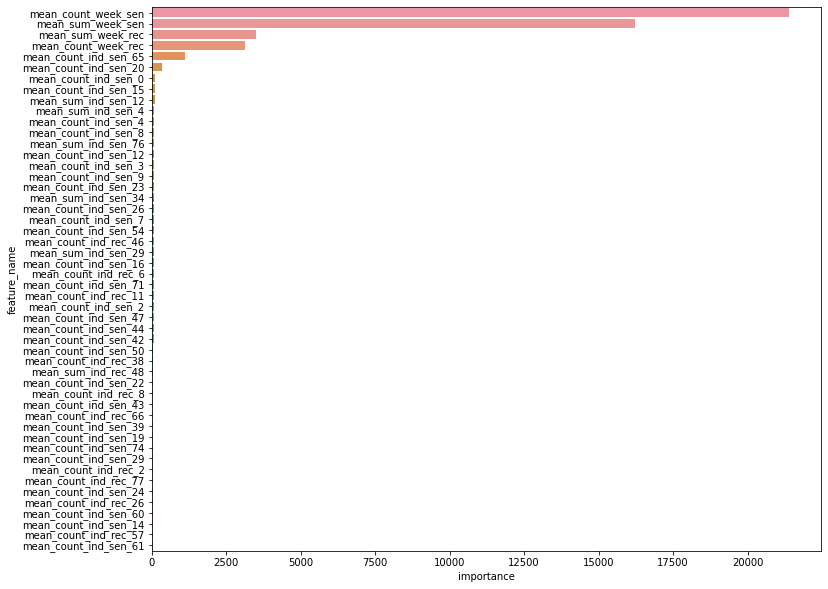

In [74]:
feature_imp_df = pd.DataFrame({'importance': model.feature_importances_, 
                               'feature_name': X.columns}).sort_values(by=['importance'], ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature_name', data=feature_imp_df[:50]);